In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/VietAI/Foundation_of_DL/torch_tutorial")


In [ ]:
zip -r rnn_tutorial.zip filename1

# NLP From Scratch: Classifying Names with a Character-Level RNN
**Author**: [Sean Robertson](https://github.com/spro)

We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words. This tutorial, along with two other
Natural Language Processing (NLP) "from scratch" tutorials
:doc:`/intermediate/char_rnn_generation_tutorial` and
:doc:`/intermediate/seq2seq_translation_tutorial`, show how to
preprocess data to model NLP. In particular these tutorials do not
use many of the convenience functions of `torchtext`, so you can see how
preprocessing to model NLP works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


## Recommended Preparation

Before starting this tutorial it is recommended that you have installed PyTorch,
and have a basic understanding of Python programming language and Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
   and learn the basics of Tensors
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data

.. Note::
   Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.

# NLP from scratch: Classifying Names with a Character-Level RNN

Chúng ta sẽ xây dựng và huấn luyện một mạng RNN cơ bản dựa trên ký tự để phân loại các từ. Hướng dẫn này sẽ hướng dẫn cách tiền xử lý dữ liệu để mô hình hóa NLP. Đặc biệt, các hướng dẫn này không sử dụng nhiều chức năng tiện ích của `torchtext`, vì vậy bạn có thể thấy cách tiền xử lý để mô hình hóa NLP hoạt động ở mức thấp.

Một mạng RNN tầng ký tự đọc từng từ như một chuỗi ký tự -
đưa ra một dự đoán và hidden state tại mỗi bước, đưa hidden state trước đó vào mỗi bước tiếp theo. Dự đoán cuối cùng
là đầu ra, tức là từ thuộc label nào.

Cụ thể, chúng ta sẽ huấn luyện trên vài ngàn họ từ của 18 ngôn ngữ
gốc, và dự đoán ngôn ngữ nào một từ thuộc về dựa trên cách viết:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


## Recommended Preparation

Một vài tài liệu về RNN:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data

.. Note::
   Download data từ
   [đây](https://download.pytorch.org/tutorial/data.zip)

Trong thư mục `data/names`, có 18 tệp văn bản được đặt tên là
`[Ngôn ngữ].txt`. Mỗi tệp chứa một danh sách tên, một tên trên mỗi
dòng, hầu hết là viết bằng chữ La tinh (nhưng chúng ta vẫn cần chuyển đổi từ Unicode thành ASCII).

Chúng ta sẽ có một từ điển chứa danh sách các tên theo từng ngôn ngữ,
``{ngôn ngữ: [các tên ...]}``. Các biến generic `category` và `line`
(cho ngôn ngữ và tên trong trường hợp của chúng ta) được sử dụng để mở rộng sau này.


In [4]:
# Code này được sử dụng để đọc và tiền xử lý dữ liệu tên người từ các tệp tin văn bản

from io import open
import glob
import os

# Định nghĩa hàm findFiles để tìm tất cả các tệp tin trong một thư mục có đường dẫn path
def findFiles(path): return glob.glob(path)

# In ra danh sách các tệp tin trong thư mục 'data/names/*.txt'
print(findFiles('data/names/*.txt'))

import unicodedata
import string

# Tạo biến all_letters chứa tất cả các ký tự trong bảng chữ cái tiếng Anh và các ký tự đặc biệt
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Hàm unicodeToAscii chuyển đổi một chuỗi Unicode thành chuỗi ASCII bằng cách loại bỏ dấu và ký tự không thuộc bảng chữ cái tiếng Anh
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# In ra kết quả sau khi áp dụng hàm unicodeToAscii lên một chuỗi Unicode
print(unicodeToAscii('Ślusàrski'))

# Tạo dictionary category_lines để lưu trữ danh sách tên theo từng ngôn ngữ
category_lines = {}
all_categories = []

# Hàm readLines đọc một tệp tin và chia thành từng dòng
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Duyệt qua tất cả các tệp tin trong thư mục 'data/names/*.txt', trích xuất ngôn ngữ từ tên tệp và lưu tên vào category_lines
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# Tính số lượng ngôn ngữ
n_categories = len(all_categories)


['data/names/Czech.txt', 'data/names/Chinese.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Arabic.txt', 'data/names/Portuguese.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/German.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.

###############

Bây giờ chúng ta có ``category_lines``, một dict cho mỗi
ngôn ngữ thành một list (tên). Chúng ta cũng có
``all_categories`` (danh sách các ngôn ngữ) và ``n_categories`` là số lượng ngôn ngữ



In [5]:
print(category_lines['Italian'][:5],
      "\n", len(category_lines['Italian']),
      "\n", all_categories)

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni'] 
 709 
 ['Czech', 'Chinese', 'Greek', 'Vietnamese', 'English', 'Korean', 'Russian', 'Scottish', 'Arabic', 'Portuguese', 'Italian', 'French', 'Dutch', 'Irish', 'Japanese', 'Spanish', 'Polish', 'German']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.


###############


### Turning Names into Tensors

Bây giờ chúng ta đã các biến chứa tên, chúng ta cần chuyển chúng thành Tensors để có thể sử dụng chúng.

Để biểu diễn một chữ cái duy nhất, chúng ta sử dụng một "one-hot vector" có kích thước
``<1 x n_letters>``. Một one-hot vector được điền bằng các số 0 ngoại trừ một số 1
tại chỉ số của chữ cái hiện tại, ví dụ: ``"b" = <0 1 0 0 0 ...>``.

Để tạo thành một từ, chúng ta nối một số vector one-hot này thành một ma trận 2D
``<độ dài dòng x 1 x n_letters>``.

Kích thước thêm 1 đó là vì PyTorch giả định rằng mọi thứ đều nằm trong batch, nên chúng ta dùng tạm batch=1

In [6]:
import torch

# Hàm letterToIndex: Tìm chỉ số của một ký tự trong biến all_letters, ví dụ: "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Hàm letterToTensor: Chuyển đổi một ký tự thành Tensor có kích thước <1 x n_letters>, mô phỏng một vector one-hot
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Hàm lineToTensor: Chuyển đổi một chuỗi thành Tensor có kích thước <line_length x 1 x n_letters>,
# hoặc một mảng các vector one-hot của các ký tự
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# In ra Tensor biểu diễn cho ký tự 'J'
print(letterToTensor('J'))

# In ra kích thước của Tensor biểu diễn cho chuỗi 'Jones'
print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from [the PyTorch for Torch users
tutorial](https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net)_)
is just 2 linear layers which operate on an input and hidden state, with
a ``LogSoftmax`` layer after the output.


###################

## Creating the Network

Trước khi có autograd, tạo RNN dùng Torch phải clone parameters nhiều lần. Còn bây h, autograd tự xử lý các.Nghĩa là build RNN bây giờ cũng như 1 mạng MLP bình thường.

Module RNN này (chủ yếu được sao chép từ [the PyTorch for Torch users
tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net))
chỉ là 2 tầng tuyến tính hoạt động trên một đầu vào và trạng thái ẩn, với
một tầng `LogSoftmax` đầu ra.




In [ ]:
import torch.nn as nn

# Định nghĩa lớp mô hình RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Lớp tuyến tính i2h: Kết hợp đầu vào và hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

        # Lớp tuyến tính h2o: Chuyển đổi hidden state thành đầu ra
        self.h2o = nn.Linear(hidden_size, output_size)

        # Hàm softmax để tính xác suất đầu ra
        self.softmax = nn.LogSoftmax(dim=1)

    # Hàm forward: Thực hiện lan truyền thuận của mạng
    def forward(self, input, hidden):
        # Kết hợp đầu vào và hidden state
        combined = torch.cat((input, hidden), 1)

        # Cập nhật hidden state bằng cách sử dụng lớp tuyến tính i2h
        hidden = self.i2h(combined)

        # Tính đầu ra từ hidden state bằng cách sử dụng lớp tuyến tính h2o
        output = self.h2o(hidden)

        # Áp dụng softmax để tính xác suất đầu ra
        output = self.softmax(output)
        return output, hidden

    # Hàm initHidden: Khởi tạo hidden state ban đầu là zero tensor
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Định nghĩa kích thước các lớp
n_hidden = 128  # Kích thước của hidden state
n_letters = 57  # Số lượng ký tự có thể xuất hiện (ví dụ: 26 chữ cái + các ký tự đặc biệt)
n_categories = 18  # Số lượng danh mục (ngôn ngữ trong trường hợp này)

# Tạo một mạng RNN với kích thước đầu vào, hidden, và đầu ra đã cho
rnn = RNN(n_letters, n_hidden, n_categories)


To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).


################


Để chạy một bước của mạng này, chúng ta cần truyền vào một đầu vào (trong trường hợp này, Tensor cho chữ cái hiện tại) và hidden state trước đó (mà chúng ta khởi tạo ban đầu là các giá trị không). Chúng ta sẽ nhận lại đầu ra (xác suất của mỗi ngôn ngữ) và hidden state tiếp theo (mà chúng ta giữ lại cho bước tiếp theo).

In [ ]:
# Đầu tiên, tạo Tensor biểu diễn cho ký tự 'A' bằng hàm letterToTensor
input = letterToTensor('A')

# Khởi tạo hidden state ban đầu là zero tensor với kích thước (1, n_hidden)
hidden = torch.zeros(1, n_hidden)

# Thực hiện bước lan truyền thuận bằng cách gọi mạng RNN
output, next_hidden = rnn(input, hidden)

# Kết quả output là tensor biểu diễn cho dự đoán đầu ra, next_hidden là hidden state sau khi thực hiện forward pass
output, next_hidden

(tensor([[-2.8715, -2.9203, -2.8477, -2.8799, -2.9268, -2.8802, -2.8392, -2.9473,
          -2.8940, -2.8724, -2.9335, -2.8342, -2.9258, -2.9514, -2.8960, -2.8315,
          -2.8234, -2.9690]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[ 0.0727,  0.1068,  0.0325, -0.0162, -0.0377, -0.0665, -0.0512,  0.0269,
           0.0321,  0.0109,  0.0656, -0.0110, -0.0751,  0.0839, -0.0285,  0.0062,
          -0.0177, -0.0021,  0.0756,  0.0299, -0.0470, -0.1044, -0.0123,  0.0422,
           0.0739, -0.0372, -0.1349,  0.0673, -0.0366,  0.0026, -0.0166, -0.0344,
          -0.0219, -0.1301,  0.0126, -0.0451,  0.0983,  0.0656,  0.0664,  0.0215,
           0.0230,  0.0496, -0.0973,  0.0199, -0.0699, -0.0204,  0.1222, -0.0049,
          -0.0691, -0.0093, -0.0541, -0.0234, -0.0320,  0.0202,  0.0223, -0.0482,
           0.0160,  0.0575, -0.1054, -0.0081,  0.0279,  0.1122,  0.0077,  0.0910,
          -0.0311, -0.0850, -0.1058,  0.0176, -0.0238,  0.0195, -0.0657,  0.0158,
          -0.0138,  0.0608, -0.0012,

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.


############################


Chúng ta không muốn tạo một Tensor mới cho mỗi bước, vì vậy chúng ta sẽ sử dụng `lineToTensor` thay vì `letterToTensor` và sử dụn slices. Điều này có thể được tối ưu hóa thêm bằng cách tính toán trước các batch Tensors.



In [ ]:
# Tạo Tensor biểu diễn cho chuỗi 'Albert' bằng hàm lineToTensor
input = lineToTensor('Albert')

# Khởi tạo hidden state ban đầu là zero tensor với kích thước (1, n_hidden)
hidden = torch.zeros(1, n_hidden)

# Thực hiện bước lan truyền thuận cho từng ký tự trong chuỗi
for i in range(input.size(0)):
    output, hidden = rnn(input[i], hidden)

# Kết quả output là tensor biểu diễn cho dự đoán cuối cùng sau khi xử lý toàn bộ chuỗi
print(output)

tensor([[-2.8351, -2.9405, -2.8564, -2.8929, -2.9281, -2.8249, -2.8042, -2.9365,
         -2.9000, -2.8401, -2.9950, -2.8074, -2.9723, -2.9822, -2.9149, -2.8787,
         -2.8123, -2.9386]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).


###################

Đầu ra là một Tensor có kích thước ``<1 x n_categories>``, trong đó
mỗi phần tử là xác suất của label đó (cao hơn có nghĩa là có khả năng hơn).



## Training
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:


######################



## Training
Preparing for Training
----------------------

Trước khi training, chúng ta nên tạo một vài hàm trợ giúp. Đầu tiên là để diễn giải đầu ra của mạng, mà chúng ta biết là xác suất của mỗi danh mục. Chúng ta có thể sử dụng ``Tensor.topk`` để lấy chỉ mục của giá trị lớn nhất:



In [ ]:
# Hàm categoryFromOutput: Chuyển đổi đầu ra của mạng thành danh mục dự đoán và chỉ số của danh mục đó
def categoryFromOutput(output):
    # Sử dụng phương thức topk để tìm chỉ số của danh mục có xác suất cao nhất
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()  # Chỉ số của danh mục dự đoán
    return all_categories[category_i], category_i

# In ra danh mục dự đoán và chỉ số của danh mục từ đầu ra đã tính toán
print(categoryFromOutput(output))


('Irish', 6)


We will also want a quick way to get a training example (a name and its
language):


###################

Chúng ta cũng muốn có một cách nhanh chóng để lấy một ví dụ huấn luyện (một tên và ngôn ngữ tương ứng):

In [ ]:
import random

# Hàm randomChoice: Chọn ngẫu nhiên một phần tử từ danh sách l
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Hàm randomTrainingExample: Tạo một ví dụ huấn luyện ngẫu nhiên từ dữ liệu
def randomTrainingExample():
    # Chọn ngẫu nhiên một danh mục từ danh sách tất cả các danh mục
    category = randomChoice(all_categories)

    # Chọn ngẫu nhiên một tên từ danh sách tên trong danh mục đã chọn
    line = randomChoice(category_lines[category])

    # Tạo Tensor cho danh mục và chuỗi tên đã chọn
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)

    return category, line, category_tensor, line_tensor

# Tạo và in ra 10 ví dụ huấn luyện ngẫu nhiên
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Bazzoli
category = Vietnamese / line = Nguyen
category = Arabic / line = Hajjar
category = Greek / line = Poniros
category = Spanish / line = Mata
category = Vietnamese / line = Than
category = Japanese / line = Satoh
category = Chinese / line = Zhang
category = Arabic / line = Antoun
category = Dutch / line = Meeuwis


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.



###############

### Training the Network

Bây giờ, để huấn luyện mạng này, chúng ta chỉ cần đưa cho nó một loạt các ví dụ (data), yêu cầu nó đoán và cho nó biết nếu nó sai.
(Negative Log Likelihood)
Đối với hàm loss, ``nn.NLLLoss`` là phù hợp, vì tầng cuối cùng của RNN là ``nn.LogSoftmax``.

Việc sử dụng nn.NLLLoss (Negative Log Likelihood Loss) làm hàm loss thích hợp khi tầng cuối cùng của RNN là nn.LogSoftmax vì nhiều lý do:

1. Log Probability Output: Tầng nn.LogSoftmax ở đầu ra cuối cùng của RNN tính toán logarithm của xác suất softmax cho mỗi danh mục. Điều này có nghĩa rằng đầu ra đã ở dạng xác suất log.

2. Log Likelihood Interpretation: nn.NLLLoss được thiết kế để hoạt động với xác suất log. Nó tính toán hàm negative log-likelihood loss, đo lường mức độ mà xác suất log dự đoán khớp với phân phối thực sự của các nhãn mục tiêu. Nó đo lường mức độ tự tin mà các dự đoán của mô hình khớp với sự thật thực sự.

3. Numerical Stability: Làm việc với log prob có thể cải thiện tính ổn định số học trong các mô hình học sâu. Tích của xác suất ở dạng gốc có thể dẫn đến các vấn đề về tràn hoặc tràn số học, đặc biệt trong các tình huống với một số lượng lớn các danh mục. Sử dụng xác suất log giúp giảm thiểu các vấn đề này.

4. Gradients for Backpropagation: nn.NLLLoss được thiết kế để tính toán đạo hàm cho việc backprop đúng cách khi sử dụng với log prob. Các fradient cung cấp thông tin cần thiết để cập nhật các tham số của mô hình trong quá trình huấn luyện thông qua gradient descent.

In [ ]:
criterion = nn.NLLLoss()


Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss


##################


Mỗi vòng lặp huấn luyện sẽ:

- Tạo các tensors đầu vào và mục tiêu (target).
- Tạo trạng thái hiddens state ban đầu bằng các giá trị không.
- Đọc từng chữ cái và

   - Lưu trạng thái ẩn cho chữ cái tiếp theo.

- So sánh đầu ra cuối cùng với mục tiêu (target).
- Thực hiện lan truyền ngược (back-propagate).
- Trả về đầu ra và giá trị hàm mất mát (loss).

In [ ]:
learning_rate = 0.005 # Tốc độ học (learning rate) là 0.005. Nếu bạn đặt giá trị này quá cao, có thể xảy ra hiện tượng "vụ nổ". Nếu quá thấp, mô hình có thể không học được.

# Hàm train: Huấn luyện mạng RNN cho một ví dụ dữ liệu huấn luyện cụ thể
def train(category_tensor, line_tensor):
    # Khởi tạo hidden state ban đầu
    hidden = rnn.initHidden()

    # Đặt gradient của mạng về zero
    rnn.zero_grad()

    # Lan truyền thuận qua từng ký tự trong chuỗi đầu vào
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Tính toán loss (hàm mất mát) bằng cách so sánh đầu ra với danh mục thực tế
    loss = criterion(output, category_tensor)

    # Tính toán gradient của loss
    loss.backward()

    # Cập nhật các tham số của mạng sử dụng gradient descent với learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.

###############

Bây giờ chúng ta chỉ cần chạy hàm đó với một loạt ví dụ. Vì hàm ``train`` trả về cả đầu ra và loss, chúng ta có thể in các dự đoán của nó và cũng theo dõi giá trị mất mát để vẽ biểu đồ. Vì có hàng ngàn ví dụ, chúng ta chỉ in ra màn hình sau mỗi ``print_every`` ví dụ, và tính trung bình của hàm mất mát.



In [ ]:
import time
import math

# Số lần lặp để huấn luyện
n_iters = 100000

# In thông tin sau mỗi bao nhiêu lần lặp
print_every = 5000

# Cập nhật biểu đồ loss sau mỗi bao nhiêu lần lặp
plot_every = 1000

# Biến để theo dõi tổng loss
current_loss = 0

# Danh sách để lưu trữ các giá trị loss để vẽ biểu đồ
all_losses = []

# Hàm tính thời gian trôi qua từ thời điểm since đến hiện tại
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Thời điểm bắt đầu huấn luyện
start = time.time()

# Vòng lặp huấn luyện
for iter in range(1, n_iters + 1):
    # Lấy một ví dụ huấn luyện ngẫu nhiên
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Huấn luyện mạng với ví dụ này và tính loss
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # In thông tin về số lần lặp, loss, tên và dự đoán
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Thêm giá trị loss hiện tại vào danh sách để vẽ biểu đồ
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 4s) 2.8065 Pham / Scottish ✗ (Vietnamese)
10000 10% (0m 8s) 1.5693 Hira / Japanese ✓
15000 15% (0m 13s) 2.1328 Donnchadh / Dutch ✗ (Irish)
20000 20% (0m 17s) 0.0378 Bakastov / Russian ✓
25000 25% (0m 21s) 1.3325 Shannon / Scottish ✗ (Irish)
30000 30% (0m 27s) 1.0904 Michalovicova / Polish ✗ (Czech)
35000 35% (0m 32s) 1.8921 Butt / German ✗ (English)
40000 40% (0m 37s) 2.3303 Russell / Dutch ✗ (Scottish)
45000 45% (0m 43s) 0.6789 Ferguson / Scottish ✓
50000 50% (0m 47s) 2.7387 Duarte / Italian ✗ (Portuguese)
55000 55% (0m 52s) 0.5588 Dang / Vietnamese ✓
60000 60% (0m 56s) 0.4205 Lao / Chinese ✓
65000 65% (1m 1s) 1.2889 Nicosia / Spanish ✗ (Italian)
70000 70% (1m 5s) 3.1689 Grosse / Scottish ✗ (German)
75000 75% (1m 9s) 0.5930 Wojda / Polish ✓
80000 80% (1m 15s) 0.0156 Glynatsis / Greek ✓
85000 85% (1m 19s) 1.5288 Ingersleben / Dutch ✗ (German)
90000 90% (1m 25s) 3.0630 Tos / Greek ✗ (Spanish)
95000 95% (1m 30s) 0.3423 Kremlacek / Czech ✓
100000 100% (1m 34s) 0.9994 Hausler /

### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:

##############
### Vẽ Biểu Đồ Kết Quả

Việc vẽ biểu đồ loss từ ``all_losses`` sẽ hiển thị quá trình học của mạng:


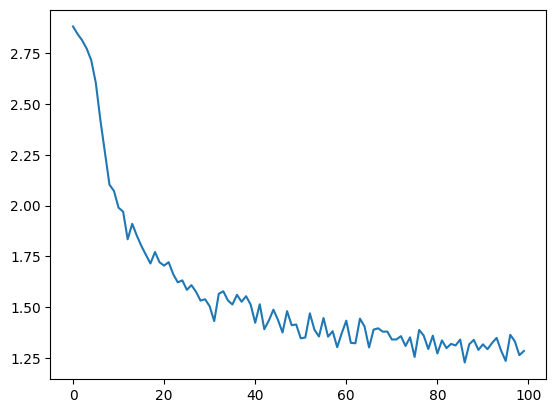

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.

##############
## Đánh Giá Kết Quả

Để xem mạng hoạt động tốt như thế nào trên các labels  khác nhau, chúng ta sẽ tạo một confusion matrix, cho biết cho mỗi ngôn ngữ thực tế (các hàng) mạng dự đoán ngôn ngữ nào (các cột). Để tính toán confusion matrix, một loạt các mẫu được chạy qua mạng với hàm ``evaluate()``, đó là hàm giống như ``train()``, nhưng không có quá trình backpropagation.


<ipython-input-40-6bd51ac5fa06>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-40-6bd51ac5fa06>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


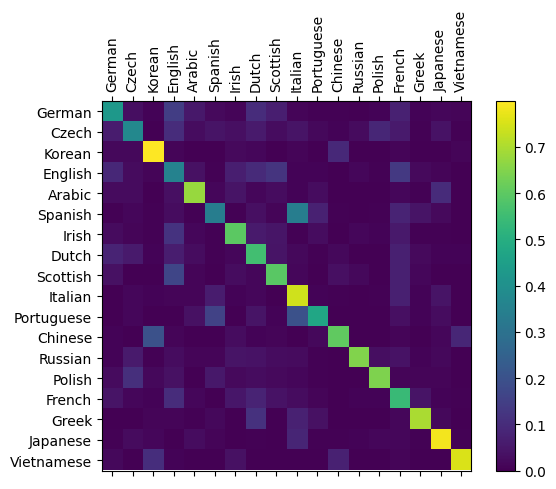

In [ ]:
# Sử dụng ma trận nhầm lẫn để theo dõi số lượng dự đoán đúng và sai
confusion = torch.zeros(n_categories, n_categories)  # Ma trận nhầm lẫn có kích thước (số lượng danh mục) x (số lượng danh mục)
n_confusion = 10000  # Số lần dự đoán để tính ma trận nhầm lẫn


# Hàm evaluate: Đánh giá đầu ra của mạng cho một chuỗi đầu vào
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Lặp qua n_confusion ví dụ và ghi lại những cái được dự đoán đúng
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia từng hàng cho tổng của nó
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Thiết lập biểu đồ
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Thiết lập các trục
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Hiển thị nhãn tại mỗi điểm đánh dấu trục
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Hiển thị biểu đồ
plt.show()


You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).

############

Bạn có thể chọn ra những điểm sáng nằm ngoài trục chính chứa thông tin về các ngôn ngữ mà mạng đoán sai, ví dụ: Tiếng Trung cho Tiếng Hàn, và Tiếng Tây Ban Nha cho Tiếng Ý. Dường như nó hoạt động rất tốt với Tiếng Hy Lạp và rất kém với Tiếng Anh (có thể do có sự chồng lấn với các ngôn ngữ khác).


### Running on User Input

############

### Chạy trên Đầu Vào của Người Dùng





In [ ]:
# Hàm predict: Dự đoán danh mục cho tên người đầu vào
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        # Tính toán đầu ra dự đoán từ tên người đầu vào
        output = evaluate(lineToTensor(input_line))

        # Lấy ra các danh mục có xác suất cao nhất (top N)
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# Dự đoán danh mục cho các tên người cụ thể
predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.74) Czech
(-1.51) Russian
(-1.76) Polish

> Jackson
(-0.62) Scottish
(-1.59) English
(-2.59) Korean

> Satoshi
(-0.59) Arabic
(-1.61) Japanese
(-1.95) Italian


The final versions of the scripts [in the Practical PyTorch
repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)_
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with ``bottle.py``)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.


###############


Các phiên bản cuối cùng của các tệp [trong kho lưu trữ Practical PyTorch](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification) đã chia mã trên thành một vài tệp:

- ``data.py`` (tải tệp)
- ``model.py`` (định nghĩa mạng RNN)
- ``train.py`` (chạy quá trình huấn luyện)
- ``predict.py`` (chạy ``predict()`` với các tham số dòng lệnh)
- ``server.py`` (cung cấp dự đoán dưới dạng giao diện API JSON với ``bottle.py``)

Chạy ``train.py`` để huấn luyện và lưu mạng.

Chạy ``predict.py`` với một tên để xem các dự đoán:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Chạy ``server.py`` và truy cập http://localhost:5533/TenCuaBan để nhận đầu ra JSON của các dự đoán.

## Exercises

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


##############

## Bài Tập

- Hãy thử với một tập dữ liệu khác về dạng từ -> danh mục, ví dụ:

   - Bất kỳ từ nào -> ngôn ngữ
   - Tên đầu tiên -> giới tính
   - Tên nhân vật -> tác giả
   - Tiêu đề trang -> blog hoặc subreddit

- Cải thiện kết quả với mạng lưới lớn hơn và/hoặc tạo hình tốt hơn

   - Thêm nhiều tầng tuyến tính hơn
   - Thử các tầng ``nn.LSTM`` và ``nn.GRU``
   - Kết hợp nhiều mạng RNN như một mạng cao cấp